In [63]:
import pandas as pd
import numpy as np
import datetime as dt

from tensorflow import keras
import tensorflow as tf
from keras.utils import timeseries_dataset_from_array

import plotly.express as px
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

### Importación de datos

Leemos el archivo y ordenamos por datetime

In [64]:
data_df = pd.read_csv('data_training/esios_data_modelo_dl.csv')
data_df = data_df.sort_values(by=['Datetime_hour']).reset_index(drop=True)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13872 entries, 0 to 13871
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Datetime_hour         13872 non-null  object 
 1   Gen.P48 Fotovoltaica  13872 non-null  float64
 2   MD                    13872 non-null  float64
 3   IDA1                  13872 non-null  float64
 4   IDA2                  13872 non-null  float64
 5   Gen.P48 Eolica        13872 non-null  float64
 6   Interconexiones P48   13872 non-null  float64
 7   Demanda P48           13872 non-null  float64
 8   Gen.P48 Total         13872 non-null  float64
dtypes: float64(8), object(1)
memory usage: 975.5+ KB


### Visualización inicial

Visualizamos la forma de la función target para las últimas 2 semanas

In [65]:
px.line(data_df.iloc[-3*24*7:], x='Datetime_hour', y='MD')

### Preparación de datos

Convertir dataframe en array

In [66]:
features = [col for col in data_df.columns if col not in ['Datetime_hour']]

data_array = data_df[features].values
data_array.shape

(13872, 8)

Reescalar los datos de entrenamiento

In [67]:
train_steps = int(0.5 * len(data_array))
val_steps = int(0.25 * len(data_array))
test_steps = len(data_array) - train_steps - val_steps

scaler = StandardScaler()
scaler.fit(data_array[:train_steps])   # fit sólo con la porción de entrenamiento
data_scaled = scaler.transform(data_array) 

Ventanas temporales

In [85]:
input_steps = 24*7
output_steps = 24

X, y = [], []

for i in range(len(data_scaled) - input_steps - output_steps):
    X.append(data_scaled[i:i+input_steps])
    y.append(data_scaled[i+input_steps:i+input_steps+output_steps, features.index('MD')])


X = np.array(X)
y = np.array(y)

Dividir en Train, Val, Test y crear datasets

In [86]:
num_train_samples = int(0.5*len(X))
num_val_samples = int(0.25*len(X))
num_test_samples = len(X) - num_train_samples - num_val_samples

X_train = X[:num_train_samples]
y_train = y[:num_train_samples]

X_val = X[num_train_samples:num_train_samples + num_val_samples]
y_val = y[num_train_samples:num_train_samples + num_val_samples]

X_test = X[num_train_samples + num_val_samples:]
y_test = y[num_train_samples + num_val_samples:]

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Train: {y_train.shape}, Val: {y_val.shape}, Test: {y_test.shape}")

Train: (6840, 168, 8), Val: (3420, 168, 8), Test: (3420, 168, 8)
Train: (6840, 24), Val: (3420, 24), Test: (3420, 24)


In [87]:
y_train

array([[ 0.80355586,  0.73707234,  0.67392492, ...,  1.81629758,
         1.48149708,  1.30420771],
       [ 0.73707234,  0.67392492,  0.60863286, ...,  1.48149708,
         1.30420771,  1.088315  ],
       [ 0.67392492,  0.60863286,  0.60005435, ...,  1.30420771,
         1.088315  ,  1.11405055],
       ...,
       [ 0.66606128,  0.4249096 ,  0.28002796, ...,  0.39917405,
         0.70609436,  0.91150221],
       [ 0.4249096 ,  0.28002796,  0.2118764 , ...,  0.70609436,
         0.91150221,  0.64175548],
       [ 0.28002796,  0.2118764 , -0.04857694, ...,  0.91150221,
         0.64175548,  0.47852534]])

In [92]:
batch_size = 64

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

### Calculo del error base

Tenemos que establecer un objetivo de precisión para nuestro modelo. Para ello, suponemos dos pronósticos iniciales:
1. El precio a la misma hora del día anterior
2. El precio a la misma hora y el mismo día de la semana anterior

Consideramos esta segunda posibilidad, debido a la gran diferencia que existe entre los precios en fin de semana y entre semana.

In [93]:
md_true = []
md_delay_week = []
md_delay_day = []

# Calculamos los targets para el dataset sin escalar
for i in range(len(data_array) - input_steps - output_steps):
    md_true.append(data_array[i+input_steps:i+input_steps+output_steps, features.index('MD')])
    # Delay de 7 dias
    md_delay_week.append(data_array[i+input_steps-24*7:i+input_steps+output_steps-24*7, features.index('MD')])
    # Delay de 1 dia
    md_delay_day.append(data_array[i+input_steps-24:i+input_steps+output_steps-24, features.index('MD')])


md_true = np.array(md_true)
md_delay_week = np.array(md_delay_week)
md_delay_day = np.array(md_delay_day)

print(f"MAE week-delay: {np.mean(np.abs(md_true - md_delay_week))}")
print(f"MAE day-delay: {np.mean(np.abs(md_true - md_delay_day))}")

MAE week-delay: 28.191819627192977
MAE day-delay: 18.685218079922034


### Modelo de Redes Neuronales Densas

In [55]:
inputs = keras.Input(shape=(input_steps, X_train.shape[-1]))
x = keras.layers.Flatten()(inputs)
x = keras.layers.Dense(32, activation="relu")(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)


callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(train_ds,
                    epochs=30,
                    validation_data=val_ds,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")

Epoch 1/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6262 - mae: 0.6172 - val_loss: 0.9053 - val_mae: 0.7552
Epoch 2/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4743 - mae: 0.5317 - val_loss: 0.7946 - val_mae: 0.7043
Epoch 3/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4425 - mae: 0.5109 - val_loss: 0.8359 - val_mae: 0.7240
Epoch 4/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4207 - mae: 0.4976 - val_loss: 0.7806 - val_mae: 0.6931
Epoch 5/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4147 - mae: 0.4934 - val_loss: 0.8043 - val_mae: 0.7005
Epoch 6/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4061 - mae: 0.4886 - val_loss: 0.7747 - val_mae: 0.6954
Epoch 7/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4001 - mae: 0.4838 - val_loss: 0.8398 - val_mae: 0.7364
Epoch 8/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3911 - mae: 0.4775 - val_loss: 0.8078 - val_mae: 0.7110
Epoch 9/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

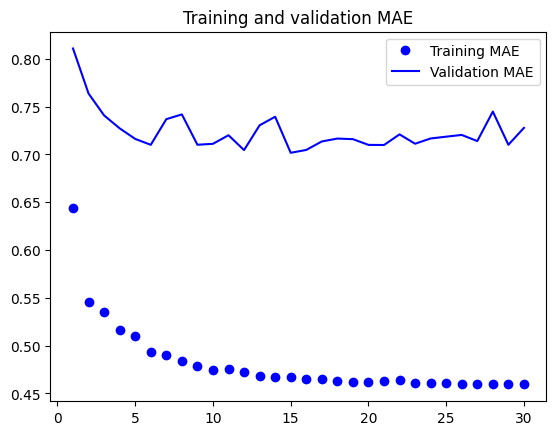

In [23]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Modelo RNN

In [95]:
inputs = keras.Input(shape=(input_steps, data_array.shape[-1]))
x = keras.layers.LSTM(64, recurrent_dropout=0.25, activation='tanh')(inputs)
x = keras.layers.Dropout(0.1)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)
]

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(train_ds,
                    epochs=30,
                    validation_data=val_ds,
                    callbacks=callbacks)

Epoch 1/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.4926 - mae: 0.5376 - val_loss: 0.6979 - val_mae: 0.6491
Epoch 2/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.4781 - mae: 0.5269 - val_loss: 0.7326 - val_mae: 0.6763
Epoch 3/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.4720 - mae: 0.5234 - val_loss: 0.7342 - val_mae: 0.6778
Epoch 4/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.4631 - mae: 0.5180 - val_loss: 0.7305 - val_mae: 0.6771
Epoch 5/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 0.4610 - mae: 0.5164 - val_loss: 0.6990 - val_mae: 0.6544
Epoch 6/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 0.4569 - mae: 0.5139 - val_loss: 0.7462 - val_mae: 0.6854
Epoch 7/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 0.4520 - mae: 0.5115 - val_loss: 0.7699 - val_mae: 0.6987


In [96]:
model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_ds)[1]:.2f}")

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.9480 - mae: 0.7946
Test MAE: 0.79


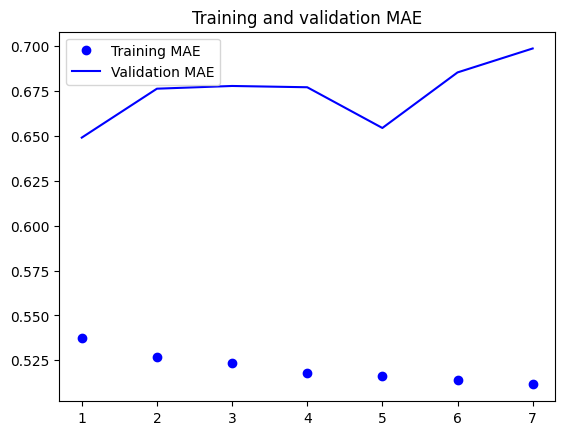

In [97]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [42]:
inputs = keras.Input(shape=(input_steps, data_array.shape[-1]))
x = keras.layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = keras.layers.GRU(16, recurrent_dropout=0.5)(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_ds,
                    epochs=20,
                    validation_data=val_ds,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_ds)[1]:.2f}")

Epoch 1/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - loss: 0.5987 - mae: 0.6151 - val_loss: 0.9638 - val_mae: 0.8057
Epoch 2/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - loss: 0.5350 - mae: 0.5745 - val_loss: 0.8724 - val_mae: 0.7561
Epoch 3/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 15s 71ms/step - loss: 0.5229 - mae: 0.5662 - val_loss: 0.8487 - val_mae: 0.7448
Epoch 4/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - loss: 0.5186 - mae: 0.5628 - val_loss: 0.8185 - val_mae: 0.7238
Epoch 5/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 17s 81ms/step - loss: 0.5149 - mae: 0.5605 - val_loss: 0.9010 - val_mae: 0.7746
Epoch 6/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - loss: 0.5146 - mae: 0.5596 - val_loss: 0.9113 - val_mae: 0.7792
Epoch 7/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 21s 99ms/step - loss: 0.5077 - mae: 0.5553 - val_loss: 0.8994 - val_mae: 0.7739
Epoch 8/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 22s 102ms/step - loss: 0.5056 - mae: 0.5553 - val_loss: 0.8267 - val_mae: 0.7332
Epoch 9/20
214/214 ━━━━━━━━━━━━━━━━━━━━

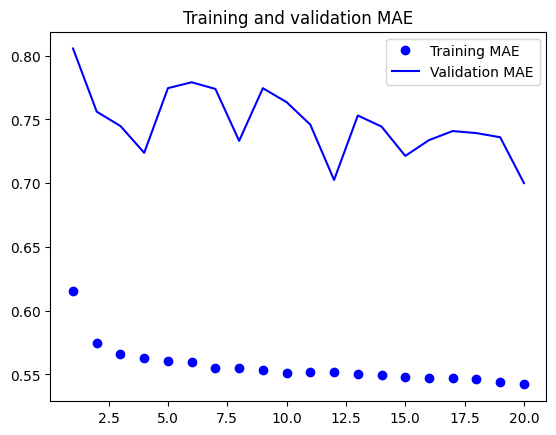

In [43]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Visualización de Resultados

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Aviso: modelo single-step vs targets multi-horizon -> compararé con el primer horizonte (col 0).
Métricas (escala original de MD):
MAE  = 30.5848
RMSE = 37.9577
MAPE = 24103327326.51%


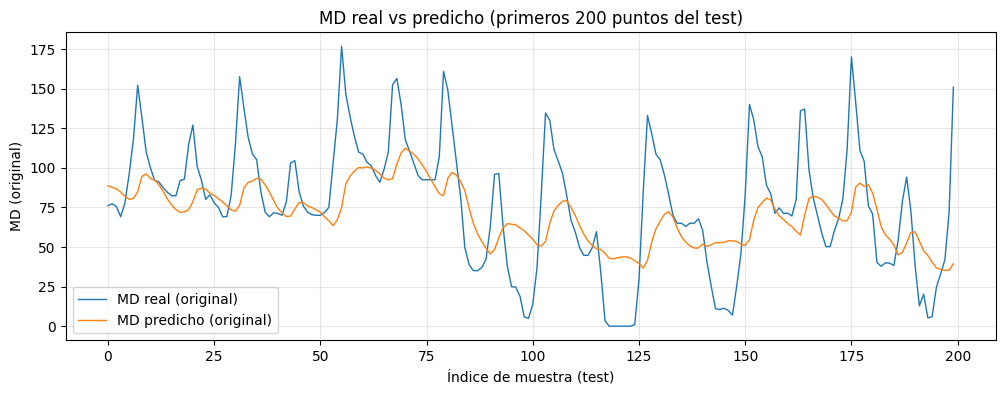

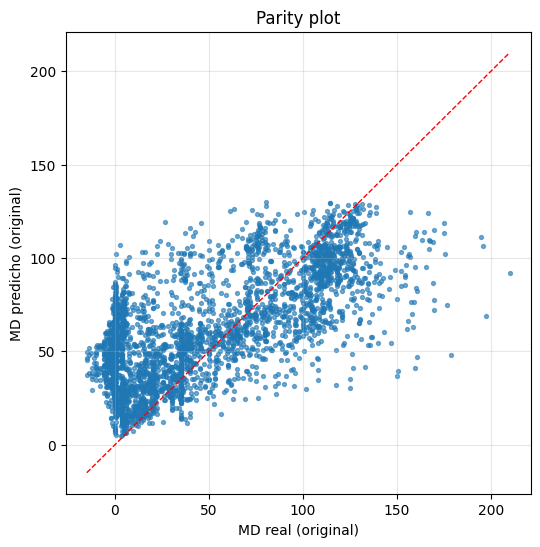

In [98]:
# ---------- 1) Recolectar y_true escalado desde test_ds ----------
# test_ds debe devolver (X_batch, y_batch)
y_true_batches = []
for _, yb in test_ds:
    # si yb es TensorFlow Tensor, convertir a numpy
    y_true_batches.append(yb.numpy() if hasattr(yb, "numpy") else yb)
y_true_scaled = np.concatenate(y_true_batches, axis=0)

# Normalizar dims
if y_true_scaled.ndim == 1:
    y_true_scaled = y_true_scaled.reshape(-1, 1)

# ---------- 2) Obtener predicciones escaladas ----------
y_pred_scaled = model.predict(test_ds)
if y_pred_scaled.ndim == 1:
    y_pred_scaled = y_pred_scaled.reshape(-1, 1)

# ---------- 3) Alinear shapes si es necesario ----------
# Si el modelo predice single-step (col=1) y los targets son multi-horizon (col>1),
# por defecto comparo la predicción con el primer horizonte (col 0).
if y_pred_scaled.shape != y_true_scaled.shape:
    if y_pred_scaled.shape[1] == 1 and y_true_scaled.shape[1] > 1:
        print("Aviso: modelo single-step vs targets multi-horizon -> compararé con el primer horizonte (col 0).")
        y_true_comp_scaled = y_true_scaled[:, 0].reshape(-1, 1)
        y_pred_comp_scaled = y_pred_scaled
    else:
        raise ValueError(f"Shapes incompatibles: y_pred {y_pred_scaled.shape} vs y_true {y_true_scaled.shape}")
else:
    y_true_comp_scaled = y_true_scaled
    y_pred_comp_scaled = y_pred_scaled

# ---------- 4) Invertir el escalado para MD usando el StandardScaler que definiste ----------
# Asumimos que 'scaler' existe y que 'features' contiene 'MD'
try:
    md_idx = features.index('MD')
except Exception:
    md_idx = 0
    print(f"Advertencia: no encontré 'MD' en 'features'. Uso md_idx={md_idx} (ajusta si es necesario).")

# Obtener media y escala desde el StandardScaler
try:
    mean_md = float(scaler.mean_[md_idx])
    scale_md = float(scaler.scale_[md_idx])
except Exception as e:
    raise RuntimeError("No he podido leer scaler.mean_ / scaler.scale_. Asegúrate de que 'scaler' exista y sea un StandardScaler fit() correctamente.") from e

def invert_md(arr_scaled):
    """Invertir escalado MD: orig = scaled * scale + mean
       arr_scaled: array (N, H) o (N,1) -> devuelve mismo shape
    """
    return arr_scaled * scale_md + mean_md

y_true_orig = invert_md(y_true_comp_scaled)
y_pred_orig = invert_md(y_pred_comp_scaled)

# ---------- 5) Métricas en escala original ----------
eps = 1e-8
def mape_np(a, b):
    return np.mean(np.abs((a - b) / (np.abs(a) + eps))) * 100

y_t = y_true_orig.ravel()
y_p = y_pred_orig.ravel()

mae_val = mean_absolute_error(y_t, y_p)
rmse_val = math.sqrt(mean_squared_error(y_t, y_p))
mape_val = mape_np(y_t, y_p)

print("Métricas (escala original de MD):")
print(f"MAE  = {mae_val:.4f}")
print(f"RMSE = {rmse_val:.4f}")
print(f"MAPE = {mape_val:.2f}%")

# ---------- 6) Visualizaciones ----------
# 6.1 Serie temporal comparada: primeros N puntos
N = 200
N = min(N, len(y_t))
plt.figure(figsize=(12,4))
plt.plot(np.arange(N), y_t[:N], label="MD real (original)", linewidth=1)
plt.plot(np.arange(N), y_p[:N], label="MD predicho (original)", linewidth=1)
plt.title(f"MD real vs predicho (primeros {N} puntos del test)")
plt.xlabel("Índice de muestra (test)")
plt.ylabel("MD (original)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 6.2 Parity plot
plt.figure(figsize=(6,6))
plt.scatter(y_t, y_p, s=8, alpha=0.6)
mn = min(y_t.min(), y_p.min())
mx = max(y_t.max(), y_p.max())
plt.plot([mn, mx], [mn, mx], "r--", linewidth=1)
plt.xlabel("MD real (original)")
plt.ylabel("MD predicho (original)")
plt.title("Parity plot")
plt.grid(alpha=0.3)
plt.show()
